# Getting Started with PyFixest

In a first step, we load the module and some example data:

In [6]:
%%capture
from pyfixest import Fixest
from pyfixest.utils import get_data

data = get_data()

In [7]:
data.head()

,Y,X1,X2,X3,X4,X5,5,6,7,8,...,15,16,17,18,19,group_id,Y2,Z1,Z2,Z3
0,NaN,0.471435,0,6,7,0.796202,0.887163,0.859588,-0.636524,0.015696,...,0.002118,0.405453,0.289092,1.321158,-1.546906,3,-1.568085,0.971477,-0.555298,4.615535
1,-1.470802,NaN,4,6,6,0.075006,-0.469305,0.675554,-1.817027,-0.183109,...,-0.122092,0.124713,-0.322795,0.841675,2.390961,20,-2.418717,NaN,5.641167,6.670944
2,-6.429899,0.076200,4,8,3,-0.471863,-0.897157,-0.136795,0.018289,0.755414,...,-0.144620,0.354020,-0.035513,0.565738,1.545659,21,-6.491542,-1.122705,5.825601,7.275710
3,-15.911375,-0.974236,4,8,2,-0.927182,-2.400454,2.030604,-1.142631,0.211883,...,2.007843,0.226963,-1.152659,0.631979,0.039513,22,-14.777766,-1.381387,3.722082,8.210927
4,-6.537525,0.464392,3,8,6,0.030819,-0.430096,0.767369,0.984920,0.270836,...,-0.081947,-0.344766,0.528288,-1.068989,-0.511881,6,-7.470515,0.327149,3.218038,8.780831


## OLS Estimation

We then initiate an object of type `Fixest`.

In [8]:
fixest = Fixest(data = data)

For this object, we can now estimate a fixed effects regression via the `.feols()` method. `.feols()` has two arguments: a two-sided model formula, and the type of inference.

In [9]:
fixest.feols("Y~X1 | X2", vcov = "HC1")

The first part of the formula contains the dependent variable and "regular" covariates, while the second part contains fixed effects.

Estimation results can be accessed via a `.summary()` or `.tidy()` method:

In [10]:
fixest.summary()

###

Model:  OLS
Dep. var.:  Y
Fixed effects:  X2
Inference:  HC1
Observations:  1998

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
    -0.26        0.18    -1.48      0.14  -0.6  0.08
---
RMSE: 8.25  Adj. R2: 0.0  Adj. R2 Within: 0.0


## Standard Errors and Inference

Supported covariance types are "iid", "HC1-3", CRV1 and CRV3 (one-way clustering). Inference can be adjusted "on-the-fly" via the
`.vcov()` method:

In [11]:
fixest.vcov({'CRV1':'group_id'}).summary()

###

Model:  OLS
Dep. var.:  Y
Fixed effects:  X2
Inference:  {'CRV1': 'group_id'}
Observations:  1998

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
    -0.26        0.16    -1.59      0.13  -0.6  0.08
---
RMSE: 8.25  Adj. R2: 0.0  Adj. R2 Within: 0.0


It is also possible to run a wild (cluster) bootstrap after estimation (via the [wildboottest module](https://github.com/s3alfisc/wildboottest), only for Python
versions smaller than `3.11`):

In [12]:
fixest = Fixest(data = data)
fixest.feols("Y~ csw(X1, X2, X3)", vcov = {"CRV1":"group_id"})
fixest.wildboottest(param = "X1", B = 999)

,param,t value,Pr(>|t|)
fml,,,
Y~X1,X1,-1.65358,0.121121
Y~X1+X2,X1,-1.617177,0.121121
Y~X1+X2+X3,X1,0.388201,0.702703


Note that the wild bootstrap currently does not support fixed effects in the regression model. Supporting fixed effects is work in progress.

## IV Estimation 

It is also possible to estimate instrumental variable models with *one* endogenous variable and (potentially multiple) instruments:

In [13]:
fixest = Fixest(data = data)
fixest.feols("Y2~ 1 | X2 | X1 ~ Z1 + Z2")
fixest.summary()


###

Model:  IV
Dep. var.:  Y2
Fixed effects:  X2
Inference:  {'CRV1': 'X2'}
Observations:  1999

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
    -0.25        0.25     -1.0      0.37 -0.93  0.44
---


If the model does not contain any fixed effects, just drop the second part of the formula above:

In [14]:
fixest.feols("Y~ 1 | X1 ~ Z1 + Z2")

IV estimation with multiple endogenous variables and multiple estimation syntax is currently not supported. The syntax is "depvar ~ exog.vars | fixef effects | endog.vars ~ instruments".

## Poisson Regression 

With version `0.8.4`, it is possible to estimate Poisson Regressions (not yet on PyPi): 

In [15]:
import pyfixest as pf
from pyfixest.utils import get_poisson_data

pdata = get_poisson_data()
fixest = Fixest(data = pdata)
fixest.fepois("Y~X1 | X2+X3+X4", vcov = {'CRV1':'X4'})

fixest.summary()

###

Model:  Poisson
Dep. var.:  Y
Fixed effects:  X2+X3+X4
Inference:  {'CRV1': 'X4'}
Observations:  1000

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
     0.87        0.04    23.78       0.0   0.8  0.95
---


## Multiple Estimation 

`PyFixest` supports a range of multiple estimation functionality: `sw`, `sw0`, `csw`, `csw0`, and multiple dependent variables. Note that every new call of `.feols()` attaches new regression results the `Fixest` object.

In [16]:
fixest = Fixest(data)
fixest.feols("Y~X1 | csw0(X3, X4)", vcov = "HC1").summary()

###

Model:  OLS
Dep. var.:  Y
Inference:  HC1
Observations:  1998

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
    -3.94        0.18   -21.31      0.00 -4.30 -3.58
    -0.27        0.18    -1.56      0.12 -0.62  0.07
---
RMSE: 8.26  Adj. R2: 0.0  Adj. R2 Within: 0.0
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  X3
Inference:  HC1
Observations:  1998

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
     0.03        0.12      0.3      0.77  -0.2  0.27
---
RMSE: 5.52  Adj. R2: -0.0  Adj. R2 Within: -0.0
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  X3+X4
Inference:  HC1
Observations:  1998

 Estimate  Std. Error  t value  Pr(>|t|)  ci_l  ci_u
     0.05        0.11     0.46      0.65 -0.16  0.26
---
RMSE: 4.98  Adj. R2: -0.0  Adj. R2 Within: -0.0


You can access an individual model by its name - i.e. a formula - via the `all_fitted_models` attribure.

In [17]:
fixest.all_fitted_models["Y~X1"].tidy()

,Estimate,Std. Error,t value,Pr(>|t|),ci_l,ci_u
coefnames,,,,,,
Intercept,-3.941395,0.184974,-21.307836,0.000000,-4.304157,-3.578632
X1,-0.273096,0.175432,-1.556710,0.119698,-0.617145,0.070952


or equivalently via the `fetch_model` method:

In [18]:
fixest.fetch_model(0).tidy()

Model:  Y~X1


,Estimate,Std. Error,t value,Pr(>|t|),ci_l,ci_u
coefnames,,,,,,
Intercept,-3.941395,0.184974,-21.307836,0.000000,-4.304157,-3.578632
X1,-0.273096,0.175432,-1.556710,0.119698,-0.617145,0.070952


Here, `0` simply fetches the first model stored in the `all_fitted_models` dictionary, `1` the second etc.

## TWFE Event Study

To conclude this intro, we estimate an event study from an example of the the [LOST](https://lost-stats.github.io/Model_Estimation/Research_Design/event_study.html) library of statistical techniques.

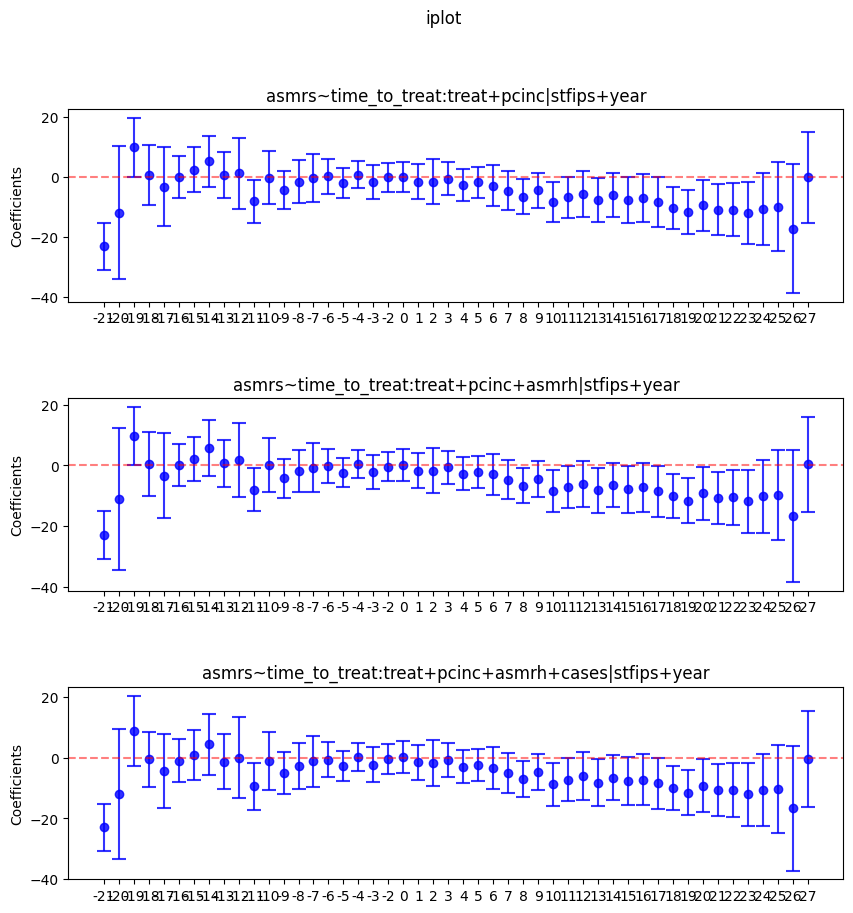

In [3]:
import pandas as pd
import numpy as np
from pyfixest import Fixest

# Read in data
df = pd.read_csv("https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv")

df['time_to_treat'] = (df['year'] - df['_nfd'] ).fillna(0).astype(int)
df['time_to_treat'] = pd.Categorical(df.time_to_treat, np.sort(df.time_to_treat.unique()))
df['treat'] = np.where(pd.isna(df['_nfd']), 0, 1)

fixest = Fixest(df)
fml = 'asmrs ~ i(time_to_treat, treat, ref = -1) + csw(pcinc, asmrh, cases) | stfips + year'
fixest.feols(fml, vcov = {'CRV1':'stfips'})
fixest.iplot(yintercept = 0)
